In [1]:
# ライブラリの読み込み

In [1]:
#  triplet networks can explicitely learn similarity between inputs:
#  -> Hoffer, Elad, and Nir Ailon. "Deep metric learning using triplet network." International Workshop on Similarity-Based Pattern Recognition. Springer, Cham, 2015.

# Here is a script for loading pretrained models in keras to finetune them in a triplet network setting
from keras.layers import Input,Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D,concatenate,Activation
from keras.applications.xception import Xception as Net
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.models import Model

import numpy as np
import cv2
import matplotlib.pyplot as plt

#-----------------------
# create model
#-----------------------
def create_model(d1,d2):
    # The triplet network takes 3 input images: 2 of the same class and 1 out-of-class sample
    input_tensor1 = Input(shape=(d1, d2, 3))
    input_tensor2 = Input(shape=(d1, d2, 3))
    input_tensor3 = Input(shape=(d1, d2, 3))
    # load a pretrained model (try, except block because the kernel would not let me download the weights for the network)
    try:
        base_model = Net(input_shape=(d1,d2,3),weights='imagenet',include_top=False)
    except:
        print('Could not download weights. Using random initialization...')
        base_model = Net(input_shape=(d1,d2,3),weights=None,include_top=False)
    # predefine a summation layer for calculating the distances:
    # the weights of this layer will be set to ones and fixed  (since they
    # are shared we could also leave them trainable to get a weighted sum)
    summation = Dense(1,activation='linear',kernel_initializer='ones',bias_initializer='zeros',name='summation')
    # feed all 3 inputs into the pretrained keras model
    x1 = base_model(input_tensor1)
    x2 = base_model(input_tensor2)
    x3 = base_model(input_tensor3)
    # flatten/summarize the models output:
    # (here we could also use GlobalAveragePooling or simply Flatten everything)
    x1 = GlobalMaxPooling2D()(x1)
    x2 = GlobalMaxPooling2D()(x2)
    x3 = GlobalMaxPooling2D()(x3)
    # calculate something proportional to the euclidean distance
    #   a-b
    d1 = subtract([x1,x2])
    d2 = subtract([x1,x3])
    #   (a-b)**2
    d1 = Lambda(lambda val: val**2)(d1)
    d2 = Lambda(lambda val: val**2)(d2)
    # sum((a-b)**2)
    d1 = summation(d1)
    d2 = summation(d2)
    #  concatenate both distances and apply softmax so we get values from 0-1
    d = concatenate([d1,d2])
    d = Activation('softmax')(d)
    # build the model and show a summary
    model = Model(inputs=[input_tensor1,input_tensor2,input_tensor3], outputs=d)
    # a second model that can be used as metric between input 1 and input 2
    metric = Model(inputs=[input_tensor1,input_tensor2], outputs=d1)
    model.summary()
    # draw the network (it looks quite nice)
    try:
        from keras.utils.vis_utils import plot_model as plot
        plot(model, to_file = 'Triplet_Dense121.png')
    except ImportError:
        print('It seems like the dependencies for drawing the model (pydot, graphviz) are not installed')
    # fix the weights of the summation layer (since the weight of this layer
    # are shared we could also leave them trainable to get a weighted sum)
    for l in model.layers:
        if l.name == 'summation':
            print('fixing weights of summation layer')
            l.trainable=False
    # compile model
    model.compile(optimizer='sgd', loss='categorical_crossentropy')
        
    return model,metric
    
triplet_model,metric = create_model(229,229)

# now we just use "triplet_model" to finetune the weights and "metric" to get the similarity between two inputs
# Input:    2 different samples of the same class, 1 sample from a different class
#           The difference between input 1 and the same-class sample should be smaller than the difference between
#           input 1 and the different-class sample

# utility function for creating images with simple shapes
def create_im(imtype = 'circle'):
    im = np.zeros((229,229,3),dtype=np.float32)
    if imtype == 'circle':
        center = (np.random.randint(10,209,1)[0],np.random.randint(10,209,1)[0])
        radius = np.random.randint(10,60,1)[0]
        cv2.circle(im,center,radius,(0,255,0),-1)
    elif imtype == 'rectangle':
        x,y = np.random.randint(10,209,1)[0],np.random.randint(10,209,1)[0]
        w,h = np.random.randint(10,60,1)[0],np.random.randint(10,60,1)[0]
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),-1)
    im = im.reshape(1,229,229,3)
    return preprocess_input(im)

# utility function for scaling input to image range
def scale_img(x):
    x = np.float32(x)
    x-=np.nanmin(x)
    if np.nanmax(x)!=0:
        x/=np.nanmax(x)
    return np.uint8(255*x)


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 7, 7, 2048)   20861480    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [6]:
im1 = create_im()
im2 = create_im()
im3 = create_im(imtype = 'rectangle')

distances = triplet_model.predict([im1,im2,im3])[0]

In [18]:
triplet_model.predict([im1,im2,im3])

array([[1., 0.]], dtype=float32)

[0. 1.]


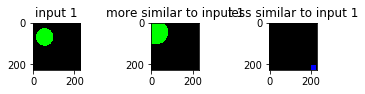

[0. 1.]
[0. 1.]
[0. 1.]


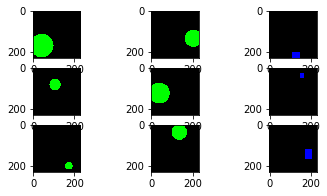

In [20]:
%matplotlib inline
# Test on some dummy images:
for k in range(4):
    im1 = create_im()
    im2 = create_im()
    im3 = create_im(imtype = 'rectangle')
    
    distances = triplet_model.predict([im1,im2,im3])[0]
    print(distances)

    plt.subplot(4,3,(k*3)+1)
    plt.imshow(scale_img(im1[0]))
    plt.subplot(4,3,(k*3)+2)
    
    if distances[0]<=distances[1]:
        plt.imshow(scale_img(im2[0]))
        plt.subplot(4,3,(k*3)+3)
        plt.imshow(scale_img(im3[0]))
    else:
        plt.imshow(scale_img(im3[0]))
        plt.subplot(4,3,(k*3)+3)
        plt.imshow(scale_img(im2[0]))
        
    if k == 0:
        plt.subplot(4,3,(k*3)+1)
        plt.title('input 1')
        plt.subplot(4,3,(k*3)+2)
        plt.title('more similar to input 1')
        plt.subplot(4,3,(k*3)+3)
        plt.title('less similar to input 1')
        plt.show()
#plt.savefig('example.png')